In [3]:
import soundfile as sf
from pydub.silence import split_on_silence
from pydub import AudioSegment

from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch

import sys
sys.path.append("/usr/local/bin/ffmpeg")

In [6]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load model and tokenizer.
processor=Wav2Vec2Processor.from_pretrained(f"classla/wav2vec2-xls-r-parlaspeech-hr")
model=Wav2Vec2ForCTC.from_pretrained(f"classla/wav2vec2-xls-r-parlaspeech-hr")

#Load audio sample. Must be in wav format with sample rate 16000.
speech=AudioSegment.from_wav(f"data/VRH-121 - 27.05.2022.wav")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [149]:
#Create chunks of loaded audio based on detected silence.
def calculate_chunks(speech: AudioSegment) -> None:
    chunks=split_on_silence (
        #Use the loaded audio.
        speech, 
        #Specify that a silent chunk must be at least 200 ms long.
        min_silence_len=200,
        #Consider a chunk silent if it's quieter than -50 dBFS.
        silence_thresh=-50,
        #After splitting add 200 ms of treshold.
        keep_silence=200,
        #Calculate every 10 ms.
        seek_step=5
    )
    #Make sure each chunk has sample rate 16000.
    for chunk in chunks:
        chunk.frame_rate=16000
    #Export chunks in wav format.
    for i in range(len(chunks)):
        chunks[i].export(out_f=f"data/chunks/chunk_"+str(i)+".wav", format="wav") 
    return

#Load wav audio file and parse using specified model and processor.
def load_parse_wav(model: Wav2Vec2ForCTC,processor: Wav2Vec2Processor,filename: str) -> (np.ndarray,float):
    #Read the wav file.
    speech, sample_rate=sf.read(filename)
    input_values=processor(speech, sampling_rate=sample_rate, return_tensors="pt").input_values.to(device)
    #Calculate duration.
    seconds=len(speech) / sample_rate
    #Retrieve logits.
    logits=model.to(device)(input_values).logits
    return logits, seconds

#Transribe parsed audio file using specified processor.
def get_transcription(processor: Wav2Vec2Processor,logits: np.ndarray) -> str:
    #Take argmax and decode.
    predicted_ids=torch.argmax(logits, dim=-1)
    transcription=processor.decode(predicted_ids[0]).lower()
    return transcription

def normalize(sound: AudioSegment, reference: int) -> AudioSegment:
    new_levels=reference - sound.dBFS
    return sound.apply_gain(new_levels)

def normalize_chunks() -> None:
    for i in range(234):
        chunk=AudioSegment.from_wav(f"data/chunks/chunk_"+str(i)+".wav")
        chunk_normalized=normalize(chunk, -3)
        #Export normalized chunks in wav format.
        chunk_normalized.export(out_f=f"data/chunks_normalized/chunk_normalized_"+str(i)+".wav", format="wav")
    return

In [ ]:
calculate_chunks(speech)
normalize_chunks()

transcription=""
for i in range(0,234):
    logits, seconds=load_parse_wav(model,processor,f"data/chunks_normalized/chunk_normalized_"+str(i)+".wav")
    print(f"chunk_"+str(i),"\t","seconds: ",seconds)
    if seconds > 1.0:
        print(f"\ttranscribing...")
        transcription += get_transcription(processor,logits) +" "
    else:
        print(f"\tignoring...")
transcription=transcription[0:-1]

with open(f"transcription_normalized.txt","w") as f:
    f.write(transcription)

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

def chunk_durations() -> pd.DataFrame:
    durations=[]
    for i in range(0,234):
        chunk=AudioSegment.from_wav(f"data/chunks/chunk_"+str(i)+".wav")
        durations.append(chunk.duration_seconds)
    return pd.DataFrame(durations, columns=["duration"])

def duration_histogram(df: pd.DataFrame, referent_max_value: float) -> None:
    f, ax=plt.subplots(figsize=(20, 13))
    sns.histplot(x="duration", data=df, label="Duration", kde=True, stat="count")
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel("Duration", fontsize=25)
    plt.ylabel("Count", fontsize=25)
    plt.show()

Number of chunks with duration less than equal 1.0 seconds: 28
Mean duration of all chunks with duration greater than 1.0 seconds: 7.37318376068376


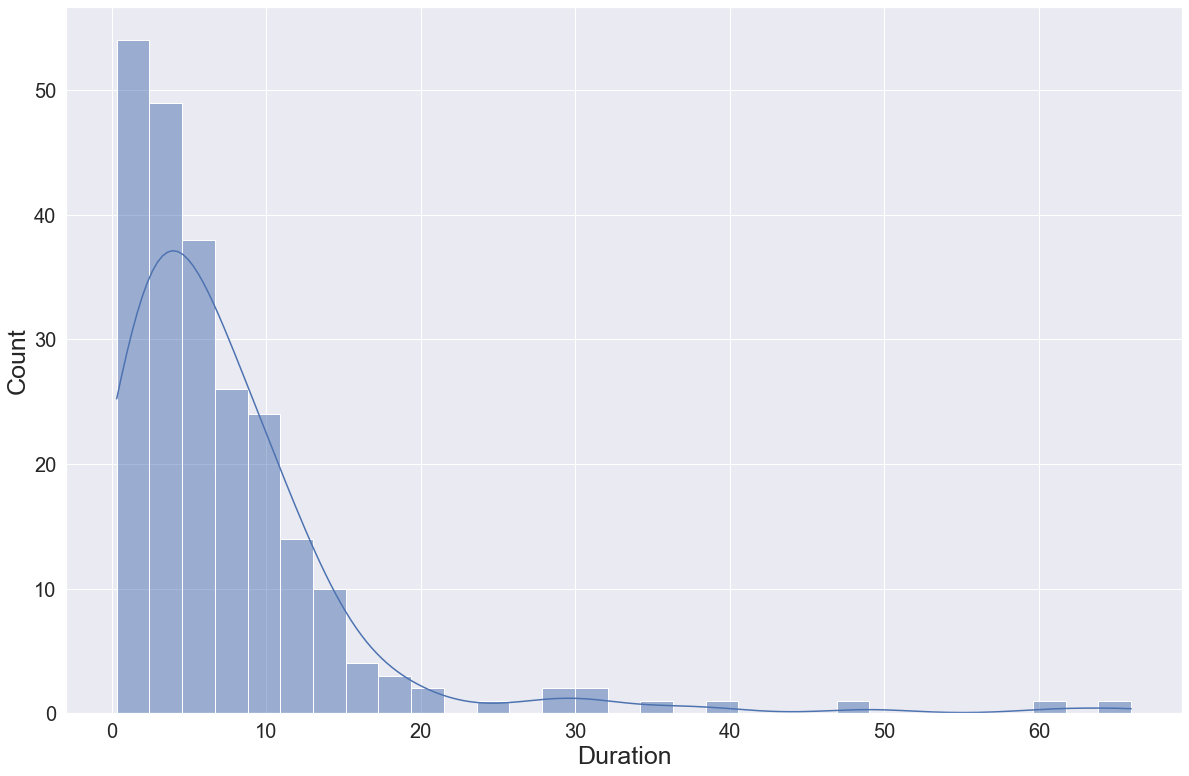

In [123]:
durations=chunk_durations()
referent_max_value=max(durations["duration"])
print(f"Number of chunks with duration less than equal 1.0 seconds:",sum(durations["duration"].apply(lambda x: 1 if x<=1 else 0)))
print(f"Mean duration of all chunks with duration greater than 1.0 seconds:",durations["duration"].apply(lambda x: 0 if x<=1 else x).mean())
duration_histogram(durations,referent_max_value=referent_max_value)

In [126]:
def word_error_plot(df: pd.DataFrame, referent_max_value: float) -> None:
    f, ax=plt.subplots(figsize=(20, 13))
    sns.barplot(x="error", y="value", hue="Error Type", data=df, palette=["#FF0048","#FCA022","#2abfcc"])
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel("", fontsize=25)
    plt.ylabel("Word Error Rate", fontsize=25)
    plt.legend(fontsize=20)
    plt.show()

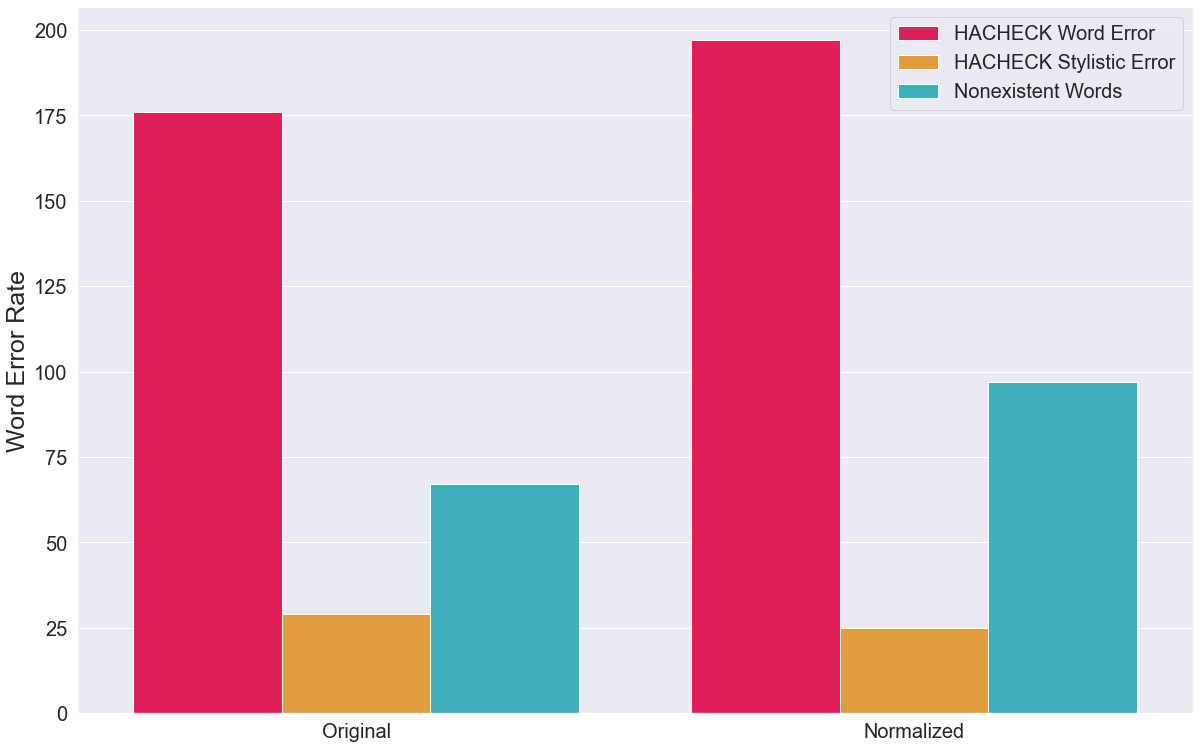

In [127]:
data={"error": ["Original","Original","Original","Normalized","Normalized","Normalized"],
        "value": [176,29,67,197,25,97],
        "Error Type": ["HACHECK Word Error","HACHECK Stylistic Error","Nonexistent Words","HACHECK Word Error","HACHECK Stylistic Error","Nonexistent Words"]}
errors=pd.DataFrame(data, columns=["error","value","Error Type"])
word_error_plot(errors,referent_max_value=220)